In [24]:
import getpass
import os
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_API_KEY'] = getpass.getpass()

#### Components

##### Chat model : NVIDIA

In [3]:
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA:")

In [4]:
llm = init_chat_model("meta/llama3-70b-instruct", model_provider="nvidia")

##### Embedding model : NVIDIA

In [5]:
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA: ")

In [6]:
embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")

##### Vector Store : InMemory

In [7]:
# # Chroma - Not working as expected getting errors
# vector_store = Chroma(collection_name="example_collection",
#                       embedding_function=embeddings,
#                       persist_directory="./chroma_langchain_db")

In [8]:
vector_store = InMemoryVectorStore(embeddings)

##### Simple indexing pipeline and RAG chain 

In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START,StateGraph
from typing_extensions import List,TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


##### Load and chunk the contents of the blog

* Document loader (Object) - to load the documents and return list of Document objects

* WebBaseLoader uses urllib to load HTML from web URLs and BeautifulSoup parses it to text 
* Customized HTML -> text parsing using bs_kwargs

* bs4 strainer only keeps post title, headers, and content from the full HTML.

In [10]:
bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))

In [11]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only":bs4_strainer},
        )

docs = loader.load()

In [12]:
assert len(docs) == 1
print(f"Total_characters: {len(docs[0].page_content)}")

Total_characters: 43130


##### Splitting Documents

* Above Loaded doc contains around 43k characters which is too long to fit into the context window of any model (Token constraints)
* Even for feasible models, large piece of text makes the model difficult to search and find matches
* To ease the retrieval process, we split the documents into chunks
* Recursive text splitter splits the doc into chunks using common separators like new lines until each chunk is the appropriate size ( Recommended text splitter for generic text use cases)

* <b> chunk_size = 1000:

            each chunk will have 1000 characters
* <b> chunk_overlap = 200:

            200 characters from the end of the previous chunk will be included in the next chunk to ensure context continuity

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap = 200,add_start_index=True)
all_splits = text_splitter.split_documents(docs)
print(f"Split the blog post into {len(all_splits)} chunks")

Split the blog post into 66 chunks


In [14]:
all_splits[:5]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from

In [15]:
for idx,chunk in enumerate(all_splits):
    print(idx,len(chunk.page_content))

0 969
1 609
2 606
3 644
4 971
5 506
6 902
7 706
8 164
9 960
10 412
11 903
12 834
13 545
14 969
15 986
16 459
17 542
18 760
19 772
20 818
21 469
22 655
23 820
24 476
25 388
26 855
27 805
28 639
29 456
30 610
31 616
32 679
33 726
34 971
35 195
36 997
37 828
38 624
39 955
40 541
41 961
42 704
43 556
44 958
45 666
46 664
47 983
48 127
49 936
50 999
51 310
52 18
53 48
54 991
55 996
56 476
57 702
58 989
59 378
60 132
61 808
62 568
63 976
64 956
65 940


##### Index Chunks

* Vector store is a defined vector db to store the embeddings of the chunks - Here ChromaDB is used
* vectors helps retrieve relevant chunks based on the similarity search with the user query / prompt

In [16]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids)

['15c4ce29-2bb9-4e1f-8911-9da4c5d98229', '697e5a46-9950-4187-8c75-6a35e75083e2', '3fe924e4-0365-42c4-b824-d6a921be762b', '0aec4661-cf00-4afc-80d3-ced0a1ff414a', '09008572-e1b4-485a-92ec-be779a167cf4', '9ba74d8b-d4d7-43c8-930f-75ea0a5e898c', '6dd84b15-e38f-4b31-bb7f-67945b5400f2', '41d8ff52-e859-4026-a5c5-d331433d2e02', '1606037d-1c30-4178-9402-49f4834179e7', 'ac186ef5-79ae-4e29-bbf6-7e792090845a', '1d1ed957-d5a6-4ac5-ac39-4dfc7277ff71', '78e143f9-c6d0-428d-a8e9-bf23ad0cd70a', 'ff045e4f-532b-4ce7-9aeb-0bec056208f1', '314ab88a-bc8d-45aa-9116-41a7402601e6', '7afb8f18-5ee4-4ce9-98af-4e995eb997f2', '5efc9712-4eb3-4a7d-9f74-08380e4d0f09', 'c531d605-cb9f-430c-9a40-1d54c96794d4', '7e2fa663-11d4-41fc-adca-0d5058bd9e85', '0585a239-749b-4cc4-926f-4183107bcddf', '60f08891-739c-44a0-9c4b-3c0a2fb4d00b', 'b0ab4ca2-db41-4ccc-b4b0-5ed7c23aac1b', '5c91f5c0-6ffe-458f-a56f-77aebffa7580', 'ab5db4ab-c0f0-4e6a-856e-f7210832079e', '3d2ade55-65af-47d6-ac6b-8b44ef4def3b', '4ee24a42-5dc1-4768-8702-bb1d5da64e62',

In [17]:
len(document_ids)

66

#####  Define prompt for question-answering

* This pulls a pre-built prompt template from langchain hub
* "rlm/rag-prompt" - prompt specifically designed for retrieval augmented question answering
* It sets up how the question + context will be sent to language model

* Prompt Template will be something like this:
* You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
* Question: (question goes here) 
* Context: (context goes here) 
* Answer:

In [18]:
prompt = hub.pull("rlm/rag-prompt")

/home/praveen/miniforge3/envs/gen_ai_env/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


##### Define state for application

* The state of the application controls what data is
    - input to the application,
    - transferred between steps, and
    - output by the application. It is typically a TypedDict


* This acts as a container to store question, context and answer

In [19]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

##### Define application steps

<b> STEP 1: Retrieval

* Takes in user's question
* Uses similarity search to find the most relevant chunk
* retrieves top_k relevant chunk based on the similarity value (k=4 by default)
* Return them as context

In [20]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

<b> STEP 2: Generation

* Joins all the retrieved chunks into a single text
* passes the question + context to the prompt
* Sends it to LLM
* Returns answer

In [21]:
def generate(state:State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer":response.content} 

##### Compile application and test

In [22]:
graph_builder = StateGraph(State).add_sequence([retrieve,generate])
graph_builder.add_edge(START,"retrieve")
graph = graph_builder.compile()

* StateGraph(State): Creates LangGraph based on State definition
* .add_sequence([retrieve, generate]): Order of execution
* add_edge(START, "retrieve"): Tells the graph to start from retrieval first
* .compile(): Finalizes the graph into an executable app

In [27]:
response = graph.invoke({"question":"What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, simpler steps. This can be done using various methods, including simple prompting, task-specific instructions, or human inputs. The goal of task decomposition is to make the task more manageable and easier to complete.


##### To visualize the control flow of the application

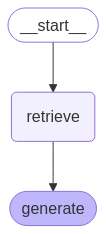

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Query Analysis

* This employs models to transform the raw user query into structured / more optimized format

In [29]:
total_documents =len(all_splits)
third = total_documents // 3
third

22

In [32]:
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8}

In [33]:
for idx, doc in enumerate(all_splits):
    if idx<third:
        doc.metadata["section"] = 'beginning'
    elif idx<third*2:
        doc.metadata["section"] = 'middle'
    else:
        doc.metadata["section"] = 'end'

In [34]:
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

##### Define schema for search query

In [35]:
from typing import Literal
from typing_extensions import Annotated

* This defines a schema for what the LLM should extract from the user’s question:

* query: what to search for.

* section: which part of the document is relevant (beginning, middle, end).

Based on the user question, LLM tries to find the section of the relevant chunk and retrieves based on the similarity , instead of just checking all the chunks 

Pre-filter chunks using metadata 

In [53]:
from pydantic import BaseModel
from typing import Literal


class Search(BaseModel):
    query: str
    section: Literal["beginning", "middle", "end"]

In [54]:
# class Search(TypedDict):
#     query : Annotated[str,...,"Search query to run."]
#     section: Annotated[
#         Literal["beginning","middle","end"],
#         ...,"Section to query",
#     ]


class State(TypedDict):
    question: str
    query: dict  # or Search if you want to keep it typed as the Pydantic model
    context: List[Document]
    answer: str

In [60]:
def analyze_query(state : State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    print("Raw LLM output:",query)
    if query is None:
        raise ValueError(
            "LLM failed to return structured output. Try checking prompt or schema."
        )

    return {"query": query.dict()}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(query["query"],filter=lambda doc: doc.metadata.get("section") == query["section"],)
    
    return {"context": retrieved_docs}

def generate(state:State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer":response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query,retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

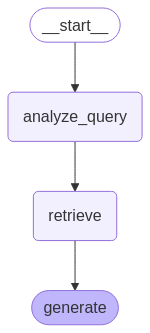

In [62]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

Raw LLM output: None


ValueError: LLM failed to return structured output. Try checking prompt or schema.

In [40]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

ValueError: Schema must be a Pydantic object, a dictionary representing a JSON schema, or an Enum.

In [71]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    print("Structured query:",query)
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
# display(Image(graph.get_graph().draw_mermaid_png()))
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

ValueError: Schema must be a Pydantic object, a dictionary representing a JSON schema, or an Enum.

In [87]:
from typing import List, TypedDict, Literal
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain import hub
from PIL import Image  # only needed if you want to visualize the graph
from langgraph.graph import StateGraph, START
from langchain_core.runnables import Runnable

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

from pydantic import BaseModel, Field
from typing import Literal, Optional


class Search(BaseModel):
    query: str = Field(..., description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(
        ..., description="Section to query."
    )



# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_core.messages import HumanMessage, SystemMessage

    # Custom prompt for structured query extraction
    system_msg = (
        "You are a helpful assistant that extracts structured data from questions. "
        "Given a user's question, extract the search query and whether the answer should be "
        "from the beginning, middle, or end of a document. "
        "Respond strictly in this JSON format:\n"
        '{ "query": "<search terms>", "section": "beginning|middle|end" }'
    )

    # Format messages manually instead of using .invoke()
    messages = [
        SystemMessage(content=system_msg),
        HumanMessage(content=state["question"]),
    ]

    # Now bind the LLM with only the schema (not a prompt)
    structured_llm = llm.with_structured_output(Search)

    try:
        # Call the LLM with the messages
        query = structured_llm.invoke(messages)

        if query is None:
            raise ValueError("Structured LLM returned None. Likely a parsing issue.")

        print("✅ Structured query:", query)
        return {"query": query}

    except Exception as e:
        print("⚠️ Structured output parsing failed.")
        raw_response = llm.invoke(messages)
        print("🔍 Raw LLM output:\n", raw_response)
        raise e


# Define retrieve node
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        filter=lambda doc: doc.metadata.get("section") == query.section,
    )
    return {"context": retrieved_docs}


# Define generate node
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Build LangGraph
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

# Run the graph
for step in graph.stream(
    {"question": "What does the post say about Task Decomposition in the end in 15-20 words?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

ValueError: Schema must be a Pydantic object, a dictionary representing a JSON schema, or an Enum.

In [93]:
prompt


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])